# <center>Работа с изображениями в ИИ.</center>

<p style="text-align:right;">выполнил: Морозов Е.А.</p>

***


## Постановка задачи.


В ходе занятия рассматривалось устройство сверточных нейронные сетей и слои пуллинга, методы оптимизации моделей для работы с gpu и реализация собственной сверточной нейронной сети. Практическая задача состоит в следующем:

- Изменить нейронную сеть из лекции

- Вычислить средние и дисперсии по выборке обучающего датасета и применить их для того, чтобы производить более качественную предобработку данных.

- Используя библиотеку albumentations, добавить дополнительные аугментации на обучающий датасет (изменение контрастности, блюр и т.д).

- Импортировать предобученную нейронную сеть vgg16 из pytorch, дообучить ее для решения той же задачи, что была в данном ноутбуке. (Необходимо заморозить протекание градиента по нейронной сети, после чего заменить последний линейный слой и менять веса только в нем).

- В случае, если модель дает качество хуже, чем наша рукописная нейронная сеть необходимо объяснить причины

- Сохранить нейронную сеть в отдельный файл и в следующей ячейке загрузить ее в новый экземпляр. После чего получить метрики на тестовом множестве изображений уже загруженной нейронной сетью.

- Выложите в git ваше решение в виде Jupyter Notebook.


### Ход работы. Предисловие. 

Ход работы вытекает напрямую из поставленной задачи: подключив библиотеки и загрузив данные, выполним задания практического занятия и составим выводы.

В первой работе по нейронным сетям было решено знакомиться с надстройкой **Keras** и выполнить задание с её использованием, но это же наложило свой отпечаток на дальнейшую работу (к счастью после первого "раунда" консуьтаций ошибки в работе 5_1 удалось вполне исправить), при этом более или менее подробное освоение **PyTorch** осталось на последующий период и для саморазвития. В текущей задаче часть вопросов исследована методами из **Tensorflow** для некоторого сравнения библиотек, а часть кода просто повторена из занятия (без подробного разбора), что представляется мне достаточным.

***

## Исследование.  

Автор честно пытался пройти оба модуля с тщанием и внимательностью, но успел охватить лишь часть диапазона. В результате составилось мнение, что **Keras** по сути годится для ознакомления с темой нейросетей, но для профессионального использования в уме стоит держать именно использование **PyTorch**. По всей видимости она позвоялет очень точно контролировать поведение и выстраивать желаемую архитектуру сетей и не даром всё-таки всё болшее количество работ производится в этой библиотеке.


### Загрузка, импорты. Описание данных. EDA.  

Сделаем импорты, установим компоненты для работы, опишем и проанализируем наблюдаемые данные.

In [1]:
# перенесём импорты в первую ячейку
#!pip install [keras, tensorflow, torch]

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras import backend as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, Flatten, Conv2D, AvgPool2D, GlobalAveragePooling2D, \
                         RandomFlip, RandomRotation, RandomZoom, Rescaling, RandomContrast, \
                         LayerNormalization, BatchNormalization

from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf
tf.random.set_seed(606) ## зафиксируем случайность через tensorflow для лучшей воспроизводимости результатов

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay                           

In [2]:
# отдельно проверим возможности переноса вычислений на GPU\TPU в PyTorch
import torch
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('GPU')
elif torch.has_mps:
    device = torch.device('mps')
    print('MPS')
    ## на 'нет' и суда нет
else:
  device = torch.device('cpu')
  print('CPU')

CPU


### Классификация изображений свёрточной нейронной сетью глубокого обучения.  

Предыдущая работа (тема 5.1) завершилась успешным подбором архитектуры свёрточной нейронной сети для классификации изображений на 10 классов:

- уже более "тяжёлая" сеть со скрытыми слоями с нелинейной активацией оставляла далеко позади по эффективности предыдущие методы (мультиклассовая логистич. регрессия и более простые нейронные сети),

- а свёрточная архитектура позволила увеличить результат, облегчив само его достижение. Тренируемых параметров получилось в несколько раз меньше, а способность к обобщению выросла. 

- Воспроизведём этот результат ниже для датасета с FashionMNIST из **Keras** дабы не загружать модельные наборы данных из **Pytorch**.  

    (Я не разобрался, как загружать датасеты **Pytorch** локально и правильно встраивать их в загрузчик. После всей этих хитростей с прямым и обратным проходом последовательность вызовов методов "торча" не помещалась в моей голове. Вдобавок я опасаюсь, что датасеты с цветными большими изображениями займут немало памяти на локальной машине и загрузка потребует времени).
  

#### Подготовка набора данных.  

Загрузим набор данных fashion_MNIST, рассмотрим разметку объектов. Отдельно подготавливать изображения и преобразовывать метки классов не станем. Также перенесём операции нормализации (по батчам) и аугментации в загрузчики данных или в компилятор (где эти функции будет удобнее использовать).

1. Загрузим датасет, оценим размеры выборок:
	X_train.shape: (60000, 28, 28)  X_test.shape: (10000, 28, 28)

2. Пример размеченных изображений из датасета:


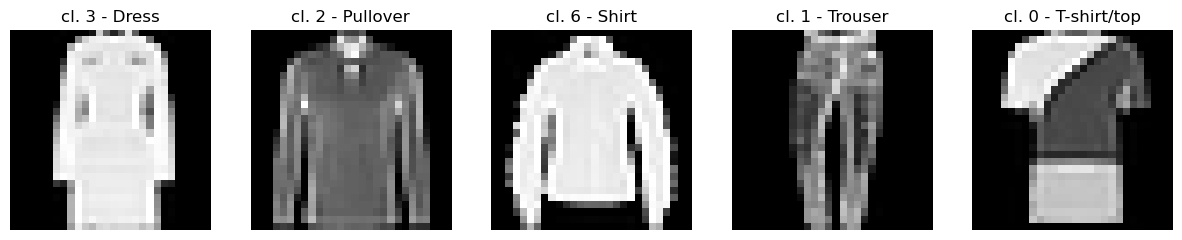

In [15]:
# загрузим датасет с изображениями всех классов
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print('1. Загрузим датасет, оценим размеры выборок:')
print('\tX_train.shape:', X_train.shape, ' X_test.shape:', X_test.shape)

# словарь с метками и расшифровк всех классов
Label_Description = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 
                     3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt',
                     7:'Sneaker', 8:'Bag', 9:'Ankle boot'}

print('\n2. Пример размеченных изображений из датасета:')
fig, ax = plt.subplots(1, 5, figsize=(15,10))
for i in range(5):
    ax[i].imshow(X_train[i+500], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'cl. {y_train[i+500]} - {Label_Description[y_train[i+500]]}')
plt.show()

#### Свёрточная нейросеть глубокого обучения для НЕобработанных входных данных.

Ниже приводится воспроизведенеие архитектуры типа **LeNet** для решения задачи классификации:


   1. Подобная архитектура используется для классификации небольших изображений (20–30 пикселей в поперечнике), на вход модели будут приходить изображения в несжатом виде соотв. размера.


   2. Сеть начинается с 2-3 свёрточных слоёв размером 5x5, чередующихся со слоями пулинга *Average Pooling* размером 2x2. Эти слои постепенно уменьшают пространственное разрешение и концентрируют информацию в матрицы маленького размера.  


   3. Чтобы не потерять важную информацию, количество фильтров растёт от слоя к слою.  


   4. В конце сети идёт 1-2 полносвязных слоя, которые собирают все признаки и классифицируют их.


   5. Первоначльно предполагалось внести аугментацию где-то на стадии загрузчика данных, но окалось, что методы `ImageDataGenerator.flow_from_directory()` в документации указываются как устаревшие и предлагается использовать более приличествующий библиотеке **sci-kit learn** подход с включением слоев предобработки, накладывающих аугметации на подаваемые батчи изобажений, в архитектуру сети.
   
   
   6. (в учебной задаче разбиение на тренировочную и валидационную части не проводилось, в качестве валидационной выборки использовалась тестовая)

In [16]:
# применим генераторы для подачи обучающих примеров в модель

class DataGenerator(Sequence):
    def __init__(self, data, labels, batch_size=64):
        self.batch_size = batch_size
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return int(np.round(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        X = self.data[index * self.batch_size : (index+1) * self.batch_size]
        y = self.labels[index * self.batch_size : (index+1) * self.batch_size]

        return X, y

# подадим данные в генераторы  и сформируем обучающий и тестовый наборы данных
train_datagen = DataGenerator(X_train, y_train)
test_datagen = DataGenerator(X_test, y_test)

print(f'Кол-во батчей, сформированных из:\n'
      +f'\t- обучающей выборки ({X_train.shape[0]} изображений, по 64 объекта в батче): {len(train_datagen)} шт.'
      +f'\n\t- тестовой выборки ({X_test.shape[0]} изображений, по 64 объекта в батче): {len(test_datagen)} шт.')

print('\nХар-ки батчей:')
for X, y in train_datagen:
    print('\t- объекты внутри X:', X.shape)
    print('\t- классы объектов внутри y:', y.shape)
    break

Кол-во батчей, сформированных из:
	- обучающей выборки (60000 изображений, по 64 объекта в батче): 938 шт.
	- тестовой выборки (10000 изображений, по 64 объекта в батче): 156 шт.

Хар-ки батчей:
	- объекты внутри X: (64, 28, 28)
	- классы объектов внутри y: (64,)


Прежде остального разберём отдельно вопрос нормализации значений выбори, поставленный в задании.

В примере ниже нормализация производилась автоматически и одинаково для всех изображений с помощью деления всех значений яркости пикселей на 255 (т.е. на макс значение) и фактически представляет из себя метод нормализации по минимальному и максимальному значениям в выборке. В данном случае одного этого оказывается достаточно, поскольку изображения в датасете являются небольшими и одноканальными (предсталены оттенками серого), а этот метод наименее затратен в плане вычислений.

Однако в случае с 3-канальнымм цветными изображениями разница в разбросе значений между каналами может быть более значимой и влиять на скорость обучения сети и сходимость, здесь более обоснованно использовать даже не нормализацию на основе среднего, а стандартизацию как таковую на основе среднего и дисперсии значений выборки, применяемую поканально и к выходным изображениям с разных этапов обработки (по слою, по батчам, по изображению). Рассмотрим соотв. значения вручную, но в итоговой имплементации будем использовать одельный слой с соотв. предобработкой - например `tf.keras.layers.LayerNormalization` или `tf.keras.layers.BatchNormalization`.

In [17]:
# рассчитаем стат.хар-ки выборок по батчам и для всей совокупности

print('Рассчитаем стат.хар-ки выборок по батчам и для всей совокупности.\n'
      + 'Значения ярокости пикселей нормирвоаны на 255. Выведем хар-ки для каждого 100-го батча.\n')
i = 0
for piece in train_datagen:
    if ((i+1)%100==0) or (i==0):
        #print(*pd.Series(piece[0].ravel()/255).describe()[1:3].values,'\n')
        print(f'{i+1}-ый батч - mean: {np.round((piece[0]/255).mean(), 8)}'
              + f', std: {np.round((piece[0]/255).std(), 8)}')
    i += 1
print(f'\nДля всей выборки - MEAN: {np.round((X_train/255).mean(),8)},'
      +f' STD {np.round((X_train/255).std(),8)}')

Рассчитаем стат.хар-ки выборок по батчам и для всей совокупности.
Значения ярокости пикселей нормирвоаны на 255. Выведем хар-ки для каждого 100-го батча.

1-ый батч - mean: 0.2879612, std: 0.35595009
100-ый батч - mean: 0.2751696, std: 0.34482358
200-ый батч - mean: 0.3009367, std: 0.36711709
300-ый батч - mean: 0.31369845, std: 0.36776129
400-ый батч - mean: 0.29791424, std: 0.36727461
500-ый батч - mean: 0.27132236, std: 0.34447439
600-ый батч - mean: 0.29359963, std: 0.36004488
700-ый батч - mean: 0.28491483, std: 0.35944122
800-ый батч - mean: 0.28991706, std: 0.34922102
900-ый батч - mean: 0.29635206, std: 0.35924717

Для всей выборки - MEAN: 0.2860406, STD 0.35302424


Очевидно, что средние величины и станд.отклонения по батчам отличаются между собой и от среднего всей совокупности (и согласно ЦПТ должны распределяться вокруг него по нормальному закону), именно на основании наличия такой разницы имеет смысл использовать стандартизации при аугментации. Точность должна вырасти по сравнению с одной лишь нормализацией на 1/255, хотя время обучения при этом скорее всего также возрастёт, учтём эти размышления в примере ниже.

In [18]:
%%time

img_height, img_width = 28, 28
tf.get_logger().setLevel('ERROR') ## много WARNING-ов со стороны библиотеки из-за аугментаций в слоях,
                                  ## т.к. рни могут замедлять обучение, подавим их вывод

# сконструируем и скомпилируем сверточную сеть, первыми добавим слои нормализации и аугментации:

model = Sequential([
    
    #нормализация:
    Rescaling(1./255, input_shape=(img_width, img_height, 1)),
    
    #слои аугментации:
    RandomFlip("horizontal", seed=606),
    RandomContrast((.2,.5), seed=606),
    RandomRotation(0.1, seed=606),
    #RandomZoom(0.1, seed=606),
    
    #стандартизация:
    BatchNormalization(axis=-1
                       , momentum=0.99
                       , epsilon=0.001
                       , center=True
                       , scale=True),
    
    #Conv2D_1:
    Conv2D(filters=6, kernel_size=(5,5), padding='same',
           input_shape=(28, 28, 1),
           activation='linear'),
    
    #avgpooling_1:
    AvgPool2D(pool_size=(2, 2), padding='same'),
    
    #Conv2D_2:
    Conv2D(filters=15, kernel_size=(5,5), padding='valid',
           activation='tanh'),
    
    #avgpooling_2:
    AvgPool2D(pool_size=(2, 2), padding='valid'),
    
    ## здесь, кается, можно добавить нормализацию слоя
    LayerNormalization(axis=-1, center=True , scale=True),

    #flatten:
    Flatten(),
    
    #dense layers:
    Dense(units=120, activation='relu'),
    #Dropout(.3),
    Dense(units=30, activation='elu'),
    Dense(10, activation='softmax')   ## sigmoid заменяется на функцию softmax
])

## зададим learning_rate оптимизатора, отличный от стандартного, для более быстрого обучения
adam = Adam(learning_rate=0.002)

## для 10 классов используем категориальную кросс-энтропию
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics='accuracy')

# выведем информацию о модели и числе тренируемых параметров
model.summary()

## снова задаем EarlyStopping
early_stopping_pic = EarlyStopping(
    monitor="val_loss",          ## монитор, отслеживающий метрику на валидации 
    min_delta=0.0001,
    patience=10,                 ## задержка перед выходом из обучения по лучшему результату
    verbose=1,
    mode="auto",                 ## режим монитора (loss - должен падать, метрика - улучшаться)
    baseline=None,
    restore_best_weights=True,   ## модель должна восстанавливаться с лучшими весами
    start_from_epoch=5,
)

## снова задаем ReduceLROnPlateau
reduce_lr_pic = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    verbose=1,
    mode="auto",
    min_delta=0.00001,
    cooldown=1,
    min_lr=1e-10
)

num_epochs = 50

history = model.fit(train_datagen,         ## генератор вместо (X_train, y_train)
          validation_data=test_datagen,
          epochs = num_epochs,           
          #batch_size=64,        ## не указыватеся, т.к. есть генератор
          #steps_per_epoch=100,  ## не указыватеся, т.к. есть генератор
          callbacks=[early_stopping_pic, reduce_lr_pic],   ## передаём callback
          shuffle=True,
          verbose=0)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 28, 28, 1)         0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 28, 28, 1)         0         
                                                                 
 random_contrast_1 (RandomCo  (None, 28, 28, 1)        0         
 ntrast)                                                         
                                                                 
 random_rotation_1 (RandomRo  (None, 28, 28, 1)        0         
 tation)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 1)        4         
 hNormalization)                                                 
                                                      


Матрица ошибок классификации (на тестовой выборке):


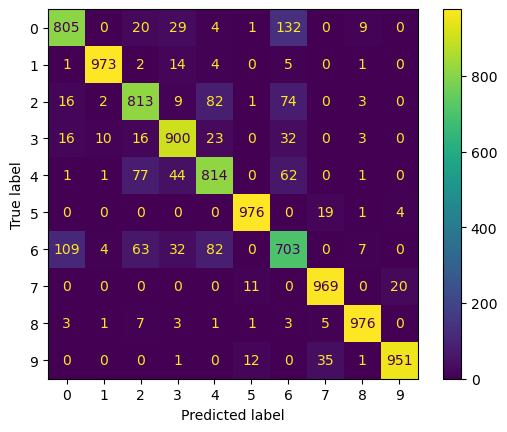

Отчёт классификации:


,precision,recall,f1-score,support
0,0.8465,0.805,0.8252,1000.000
1,0.9818,0.973,0.9774,1000.000
2,0.8146,0.813,0.8138,1000.000
3,0.8721,0.900,0.8858,1000.000
4,0.8059,0.814,0.8100,1000.000
5,0.9741,0.976,0.9750,1000.000
6,0.6954,0.703,0.6992,1000.000
7,0.9426,0.969,0.9556,1000.000
8,0.9741,0.976,0.9750,1000.000
9,0.9754,0.951,0.9630,1000.000



Графики хода процесса обучения модели.


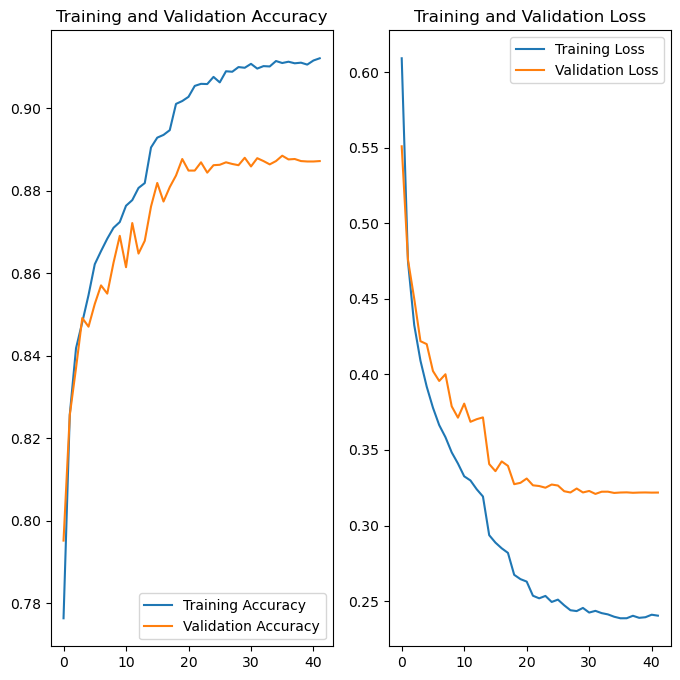

In [19]:
## выведем матрицу ошибок и отчёт классификации (функция)

# выборки для отчёта
y_true = y_test
y_pred = [x.argmax() for x in history.model.predict(X_test, verbose=0)]

def report_and_graph(fitted_model, y_true, y_pred):
    # матрица ошибок
    print('\033[1m'+'\nМатрица ошибок классификации (на тестовой выборке):'+'\033[0m')
    ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot()                             
    plt.show()

    # отчёт классификации
    print('\033[1m'+'Отчёт классификации:'+'\033[0m')
    report = classification_report(y_true, y_pred, digits=4, output_dict=True)
    display(pd.DataFrame(report).round(4).transpose())

    # графики процесса обучения модели
    acc = fitted_model.history['accuracy']
    val_acc = fitted_model.history['val_accuracy']

    loss = fitted_model.history['loss']
    val_loss = fitted_model.history['val_loss']

    epochs_range = range(len(fitted_model.epoch))

    print('\033[1m'+'\nГрафики хода процесса обучения модели.'+'\033[0m')
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    
report_and_graph(history, y_true, y_pred)

Нормализация замедляет процесс обучения, но улучшает итоговое качество.


#### Предобученная свёрточная нейронная сеть известной архитектуры.  


В полносвязных сетях обычно содержится не более 2–5 скрытых слоёв по нескольким причинам:

- поскольку даже трёх полносвязных слоёв с нелинейной активацией теоретически достаточно, чтобы научиться чему угодно, но за неопределнное количество времени.

- Однако наряду с этим также существует проблема затухания градиента.

Частично она решалась с помощью добавления свёрточных слоёв, у таких сетей меньше тренируемых параметров, чем у полносвязных, поэтому к ним можно добавлять больше слоёв. Но затухание градиента происходит и в свёрточных нейросетях. Насколько мне удалось понять, у "знаковых" представителей было порядка 20 слоёв (что принято отражать в названии вида *VGG16* или *VGG19*). При большем количестве новые слои уже не улучшали качество, так как первые переставали обучаться. На таком фоне архитектура **ResNet** возникла именно для того, чтобы решить проблему затухающего градиента в очень глубоких слоях. Главная особенность заключается в использовании *Shortcut Connections \ Skip Connections* — таких связей внутри сети, которые позволяют "пробрасывать" значения нейронов через слои и избежать проблемы затухания. Благодаря этому стало возможно обучать сети глубиной в сотни слоёв. 

В лекции шла речь о сравнении сетей на примере архитектур **VGG16** и **ResNet**. Поскольку в моём понимании **ResNet** явилась этапом эволюции свёрточных нейросетей следующим после **VGG** (и судя по сравнтельным таблицам она имеет ряд преимуществ перед последней, в частности по соотношению объём файла с весами связей сети при достигаемой точности классификации), то по этой причине хочется использовать именно её. Как выяснилось в ходе экспериментов, не стоит забывать, что при решении отдельных узкоспециализированных задач или на небольших тренировочных выборках сильно сказывается предобученность и широчайший диапазон действия "резнет-сети", что даст идеальные предсказания на обучающей выборке и случайные на тестовой из-за переобученности. Т.е. применение вполне может оказаться неоправданным и с такой ситуацией нужно либо бороться некоторыми ухищрениями, либо обучать сети предыдущих архитектур с 0 под выбранную задачу.

~~~python
# импортируем ResNet из Keras с количеством слоёв в сети = 50.
from tensorflow.keras.applications.resnet import ResNet50

# положим сеть целиком в модель
model = ResNet50(input_shape=None,
                 classes=1000,
                 include_top=True,
                 weights='imagenet')
~~~

здесь аргументы:

- `input_shape` — размер входного изображения (напр.: (640, 480, 3)).

- `classes=1000` — кол-во нейронов в последнем полносвязном классифицирующем слое.

- `weights='imagenet'` — инициализация весов гигантского датасета ImageNet, на котором сеть первоначально обучалась классифицировать изображения на 1000 классов. Чтобы инициализация весов была случайной указывают `weights=None`. Решение при инициализации весов от ImageNet должно давать результат лучше и быстрее, чем если обучать с нуля.

- `include_top=True` — в архитектуре ResNet в конце есть два слоя: *GlobalAveragePooling2D* и *Dense*.

    - это слой пулинга с окном во весь тензор, который усредняет информацию по всему изображению, и на выходе выдаёт 1 пиксель с большим количеством каналов (512 для ResNet50),

    - и один полносвязный слой для классификации,

    - задав `include_top=False`, этих слоёв уже не будет, что можно использовать для решения своих задач, создавая слои "верхушки" на своё усмотрение,
    
    - "замораживание" оставшейся части сети - это второе, что можно применить для решения частной задачи или небольшой выборки. Обучать всю сеть заново в таком случае нелогично, из-за огромного кол-ва параметров она переобучится. Если некоторые слои оставить с весами, полученными на ImageNet, то они уже не будут обучаться градиентным спуском и меняться. Так количество параметров сети уменьшится, но архитектура сохранится. Обучать стоит только 1–2 полносвязных слоя наверху сети.
    
На использовавшихся выше изображениях набора данных fashion_MNIST наша сеть работать не сможет, они 1-канальные и слишком маленькие, используя набор данных из соотв. соревнования на **kaggle**, попробуем решить задачу классификации на 3 класса.

Веса связей сети и набор данных загружались локально, отдельно также пришлось рассмотреть вопрос, связанный с переносом вычислений на графич. ускоритель, а также с размещением набора данных в памяти в связи с ростом размеров изображений, подаваемых на вход нейросети. Здесь удобной оказалась "прозрачность" переноса вычислений на GPU в Google Colab при использовании TensorFlow.

In [8]:
## кусок кода на случай выполнения в Google Colab
## было актуально пока там можно было использовать GPU, но в конце концов GPU отобрали и оказалось
## что локально разрабатывать несколько дольше, но гораздо стабильнее

#from google.colab import drive
#drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [9]:
tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# к счастью в конце концов удалось понять откуда брать датасет с изображениями
# и как брать их из папки батчами, воспроизведём механизм ниже

bs = 32
dim = 128

train_ds = image_dataset_from_directory(
    directory='C:/Users/Morodze/Desktop/trash/1T_DE/ML/5_CV/afhq/train',
    labels='inferred',
    label_mode='int',
    batch_size=bs,
    image_size=(dim, dim),
    shuffle=True,
    seed=606)

validation_ds = image_dataset_from_directory(
    directory='C:/Users/Morodze/Desktop/trash/1T_DE/ML/5_CV/afhq/val',
    labels='inferred',
    label_mode='int',
    batch_size=bs,
    image_size=(dim, dim),
    shuffle=True,
    seed=606)

Num GPUs Available:  0
Found 14630 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.


In [10]:
# имена классов датасетов
print(*train_ds.class_names)

cat dog wild


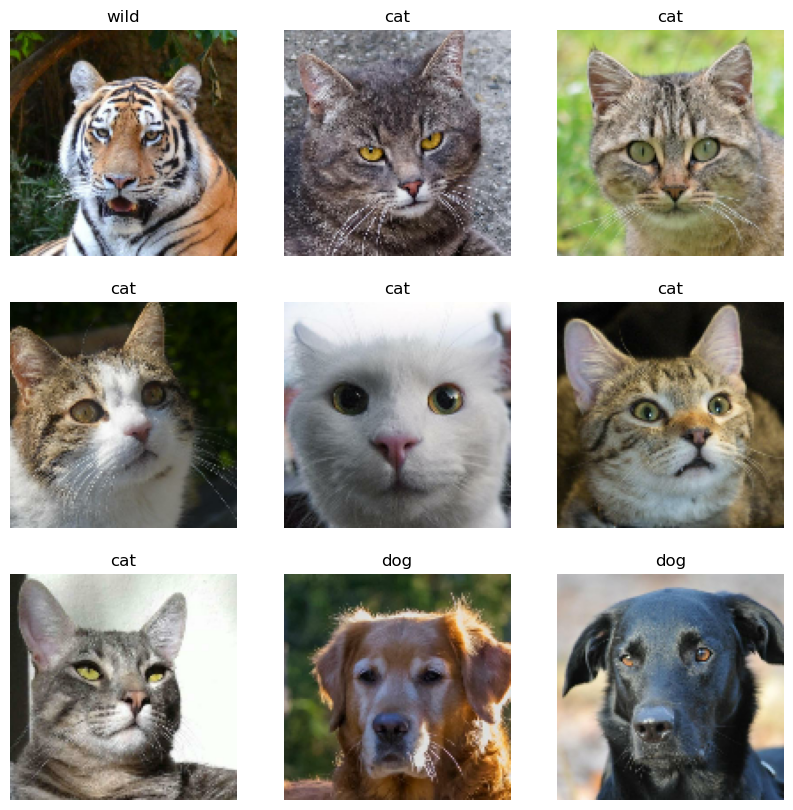

In [11]:
# примеры изображений в выборке с указанием класса объекта
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [12]:
%time
# в соотв. с вышесказанным об импорте модели загрузим и обучим сеть ResNet50

# импортируем ResNet из Keras с количеством слоёв в сети = 50
from tensorflow.keras.applications.resnet import ResNet50

backbone = ResNet50(input_shape=(dim, dim, 3),
                    weights='imagenet', 
                    include_top=False)

# "замораживаем" слои ResNet50 (без верхушки, её убрали при инициализации выше)
backbone.trainable = False

# конструируем сеть заново из остатка backbone и новых слоёв
model_rn50 = Sequential()
model_rn50.add(backbone)
model_rn50.add(GlobalAveragePooling2D())
model_rn50.add(Dense(3, activation='softmax'))

## зададим learning_rate оптимизатора
adam = Adam(learning_rate=0.01)

## для 10 классов используем категориальную кросс-энтропию
model_rn50.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics='accuracy')

# выведем информацию о модели и числе тренируемых параметров
model_rn50.summary()

## снова задаем EarlyStopping
early_stopping_pic = EarlyStopping(
    monitor="val_loss",          ## монитор, отслеживающий метрику на валидации 
    min_delta=0.0001,
    patience=3,                  ## задержка перед выходом из обучения по лучшему результату
    verbose=1,
    mode="auto",                 ## режим монитора (loss - должен падать, метрика - улучшаться)
    baseline=None,
    restore_best_weights=True,   ## модель должна восстанавливаться с лучшими весами
    start_from_epoch=3,
)

## снова задаем ReduceLROnPlateau
reduce_lr_pic = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.25,
    patience=2,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=1,
    min_lr=1e-10
)

num_epochs = 30

history_rn50 = model_rn50.fit(train_ds,              ## генератор вместо (X_train, y_train)
                              validation_data=validation_ds,
                              epochs = num_epochs,           
                              #batch_size=64, steps_per_epoch=100,  ## не указываются, есть генератор
                              callbacks=[early_stopping_pic, reduce_lr_pic],   ## передаём callback
                              shuffle=True,
                              verbose=1)

Wall time: 0 ns
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_3 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 23,593,859
Trainable params: 6,147
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/30
458/458 [==============================] - 272s 587ms/step - loss: 0.2059 - accuracy: 0.9754 - val_loss: 0.1605 - val_accuracy: 0.9860 - lr: 0.0100
Epoch 2/30
458/458 [==============================] - 270s 59


Матрица ошибок классификации (на тестовой выборке):


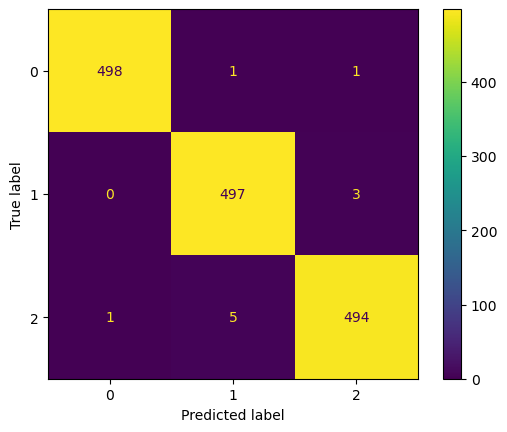

Отчёт классификации:


,precision,recall,f1-score,support
0,0.9980,0.9960,0.9970,500.0000
1,0.9881,0.9940,0.9910,500.0000
2,0.9920,0.9880,0.9900,500.0000
accuracy,0.9927,0.9927,0.9927,0.9927
macro avg,0.9927,0.9927,0.9927,1500.0000
weighted avg,0.9927,0.9927,0.9927,1500.0000



Графики хода процесса обучения модели.


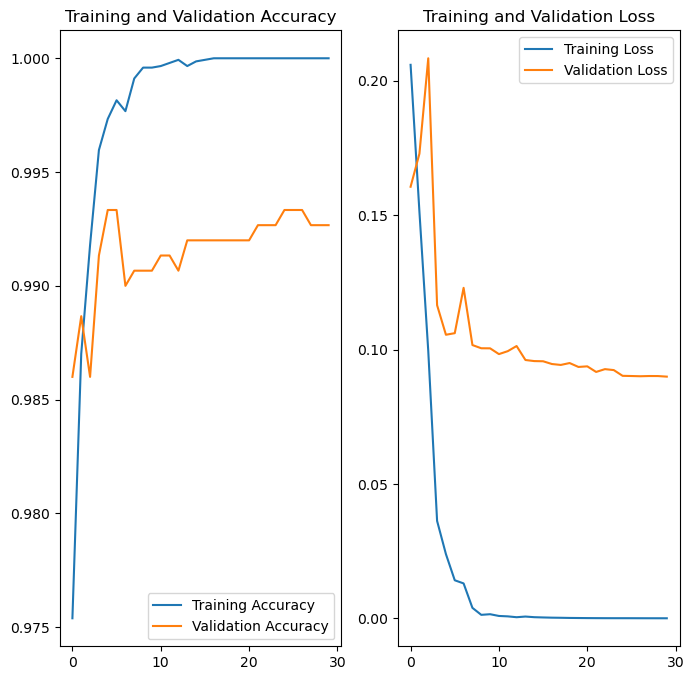

In [13]:
y_true = []
y_pred = []

# проитерируемся по объектам батчей, чтобы последовательно собрать предсказания
# модели и соответствующие метки классов в верной последовательности

for X, y in validation_ds:
  for el in y.numpy():
    y_true.append(el)    ## заносим истинные метки классов объектов в соотв.список
  for el_x in [x.argmax() for x in model_rn50.predict(X, verbose=0)]:
    y_pred.append(el_x)  ## в той же последовательности заносим в соотв.список
                         ## предсказания модели на объектах тестовой выборки 

## выведем матрицу ошибок и отчёт классификации

report_and_graph(history_rn50, y_true, y_pred)

Я вполне отдаю себе отчёт в погрешностях, возникающих при обучении без отложенной тестовой выборки для полноценной проверки и ряда других допущений (размер батча и размер изображений на входе), но в данном случае для выполнения обучения за вменяемое время пришлось идти на некоторые компромиссы, но для учебной задачи подход выше кажется вполне показательным и довольно успешным.

Разобравшись и установив верный порядок итераций по объектам и истинным меткам классов батчей тестовой выборки (и предсказаний на них), всё встало на свои места и решение стало на самом деле эффективным, как мне кажется.

В данном случае, чтобы избежать вопросов об эфективности различных *до-**ResNet**-архитектур* и сравнений их между собой, выбор сразу был сделан в пользу импорта и решения именно с использованием *ResNet50* как превосходящего решения для предшествующих архитектур. Хотя не стоит забывать, что и предшествующие решения в своё время смогли добиться выдающихся результатов в задачах, присущих тем этапам развития и ничто не мешает продолжать их использование и повторять теже успехи. Вдобавок из-за меньшего числа параметров, даже при их относительно большом количестве, такие нейросети должы получиться "меньше и легче" огромной *ResNet*.


### Сохранение модели, загрузка. Выводы.


При довольно неглубоком (в силу определённых ограничений) изучении способов сохранения моделей и их параметров удалось установить, что в **Tensorflow** существует не один такой способ, а также множество методов доступа к такому сохранённому объекту, с пом. которых можно подробно изучать и повторять процесс обучения модели, извлекать и переносить веса отдельных слоёв, и даже продолжать обучение моделей с достигнутого уровня. Это должно быть удобно, когда спроектированную и обученную модель требуется сохранять для последующего ее использования в прикладных задачах, либо создавать контрольные точки в процессе обучения на случай сбоя. Ниже рассатривался только самый базовый функционал процесса сохранения. 

В самом простом случае сохранени модели осуществляется методом `.save()` (или `tf.keras.models.save_model())`), метод `keras.models.load_model()` вызывается для загрузки модели по указанному пути. Классически при этом происходит "прогон" тестовой выборки через загруженную модель: `loaded_model.evaluate(x_test, y_test)`. В результате в рабочем каталоге появится папка с именем сохранённой модели, содержащая ряд подкаталогов и файл с архитектурой модели, конфигурацией обучения и многими параметрами модели. Все это доступно, если модель сохраняется в формате **Tensorflow** – `SavedModel`. Данные так же можно сохранить в формате **.h5**, в котором сохраняется только архитектура модели, веса и информация метода `compile()`, т.е. процесс обучения продолжить в сучае такого сохранения не получится.

По умолчанию сохранение происходит в формат SavedModel, для использования формата .h5, нужно указать расширение файла или установить соотв. параметр `save_format='h5'`:

In [14]:
# сохраним и затем загрузим модель из файла и проверим правильность функционирования на простом примере

model_rn50.save('test_nn_rs50', save_format='h5', overwrite=True)
loaded_model = tf.keras.models.load_model('test_nn_rs50')

inside_model_predict = np.array([y.argmax() for y in model_rn50.predict(X, verbose=0)])
loaded_model_predict = np.array([y.argmax() for y in loaded_model.predict(X, verbose=0)])

print('\t- предсказания модели:\n', inside_model_predict, '\n')
print('\t- предсказания загруженной модели:\n', loaded_model_predict)

if np.sum(loaded_model_predict - inside_model_predict)==0:
    print('\n\033[1m'+'Результаты моделей (сохраняемой и загруженной из файла) совпадают!'+'\033[0m')
else:
    print('\n\033[1m'+'Не работает!'+'\n\033[0m')

	- предсказания модели:
 [1 0 0 0 2 1 1 0 2 1 0 0 1 2 0 1 0 2 1 1 1 1 0 2 1 1 2 2] 

	- предсказания загруженной модели:
 [1 0 0 0 2 1 1 0 2 1 0 0 1 2 0 1 0 2 1 1 1 1 0 2 1 1 2 2]

Результаты моделей (сохраняемой и загруженной из файла) совпадают!


Разумеется, всюду рекомендуется использовать формат **SaveModel** при сохранении моделей, но в общем случае формат должен определяться рабочими процессами, вокруг созданной модели.

**Выводы:**

- Искомый результат исследования - освоение и успешное применение концепций компьютерного зрения с применением нейро-сетевых алгоритмов - был достигнут, работа не без недочётов, конечно, но завершена.


- Задания удалось решить во фреймворке **TensorFlow** и посомтреть аналогичные методы в **Pytorch** (перенести решение и повторить его я не успевал), однако вопрос о том, какой фреймворк и в каком случае предпочтительнее, остаётся открытым. Ожидалось, что к концу исследования станет ясно преимущество одной библиотеке над другой или определится приоритетная сфера применения (допустим, TF-для решения бизнес-задач и скорейшего вывода моделей в продакшн, а Pytorch - для исследовательских задач), но этого не произошло. 


- Хочется выразить благодарность преподавателям модулей по нейронным сетям и машинному обучению, темы хоть и заключены буквально в пару занятий каждая, но имеют под собой несравненно больший пласт теории и практики применения, что вызывает просто восторг и желание изучать и применять в работе и на деле понимание применяемых методов дико полезно всем специальностям, посвященным работе с данными.